---
title: "Champagne for my real friends"
subtitle: Real pain for my sham friends, real tricks for my meh friends, and finding more like this with NLP
author: 
 - name: "Jeremy B. Merrill"
   url: https://www.jeremybmerrill.com
date: today
title-block-banner: true
format: 
  html:
    code-fold: true
    toc: true
toc-depth: 3
jupyter: python3
open-graph:
   title: Real tricks for my meh friends, real croc for my faux friends
   description: "'Champagne for my real friends, real pain for my sham friends' is clever. Let's find more phrases like that with NLP."
   image: https://jeremybmerrill.com/images/folkrock_croc.png
---

What a catchy phrase. Someone [nerd-sniped me](https://xkcd.com/356/) in July, essentially daring me to find some more. Here's how I tricked the computer into coming up with more `champagne phrases` like this, using natural language processing tools like 

- the CMU Pronouncing Dictionary
- GLoVe
- a wordlist with frequencies
- WordNet

::: {.callout-note collapse="true"}
## Click for a sample of the final output (spoiler alert!)

- metrics for my real friends, real tricks for my meh friends
- focus for my real friends, real cuss for my faux friends
- shamrocks for my real friends, real rocks for my sham friends
- folkrock for my real friends, real croc for my faux friends
- photos for my real friends, real toes for my faux friends
- midrash for my real friends, real rash for my mid friends
- medics for my real friends, real dicks for my meh friends
- crappie for my real friends, real pee for my crap friends
:::

## But how do computers know how words sound?

The [CMU Pronouncing Dictionary](www.speech.cs.cmu.edu/cgi-bin/cmudict) is a classical natural language processing resource that lists words and their pronunciations. It's thirty years old! It was compiled by humans who painstakingly listed each word's pronunciations -- no neural nets or artificial intelligence here.

::: {.callout-tip collapse="true"}
## What is classical NLP? Why not use ChatGPT?

So-called classical natural language processing relies on computational representations of the kinds of grammar concepts used by linguists. Think back to middle-school English class. You learned about nouns and verbs and how to diagram a sentence. Natural language processing analyzes language with those kinds of representations.

This differs from AI-based NLP, whose representation of language tends to be more of black box. That black box representation is good for a lot of things, but it's famously terrible at computational humor.

Here's what ChatGPT gave me when I asked it for _can you come up with some variants on the "champagne for my real friends, real pain for my sham friends?" template, but using different words than champagne, sham and pain?_.

1. "Laughter for my true friends, heartfelt tears for my false friends."
2. "Confetti for my loyal friends, bitter truth for my deceitful friends."
3. "Hugs for my genuine friends, icy distance for my deceptive friends."
4. "Sunshine for my authentic friends, thunderstorms for my treacherous friends."

Those are terrible! They don't follow the template at all! We can do better with classical NLP.

(But if you can coax better examples out of ChatGPT, let me know!)
:::

If we're gonna find more slogans like _champagne for my real friends, real pain for my sham friends_, we'll have to find words like _champagne_ that **sound** like compounds of a word like _sham_ and a word like _pain_ -- regardless of how they're spelled.

Another example of what we're looking for is _focus for my real friends, real cuss for my faux friends_. In this example, _focus_ is our `champagne compound word`, and it's composed of _faux_ (a `sham word`) and _cuss_ (a `pain word`).

Look below to see what the pronunciation of _champagne_ looks like, and how it's made up of the pronunciations of _sham_ and _pain_.

(Throughout this post, sections of computer code are collapsed. If you want to see the Python code that makes this project work, click the little gray arrow on the left to expand the code.)

In [1]:
#| code-fold: true
#| code-summary: "print a few pronunciations"

import cmudict
cmudict_dict = cmudict.dict()

for word in ["champagne", "sham", "pain"]:
    print("pronunciation of {} is {}".format(word, cmudict_dict[word]))


pronunciation of champagne is [['SH', 'AE0', 'M', 'P', 'EY1', 'N']]
pronunciation of sham is [['SH', 'AE1', 'M']]
pronunciation of pain is [['P', 'EY1', 'N']]


## An initial rubric for a `champagne phrase` 

A `champagne phrase`: `sham word` is an adjective and a `pain word` is a word that, when their pronunciations are combined, make a `champagne compound word`.

We'll revise this later, but this is enough to try to get started with generating `champagne phrases.`

## Implementing our initial rubric

Let's use "faux" as our `sham word`. So we're looking for phrases like _faux pain for my real friends, real pain for my faux friends_... except where _faux pain_ is a real word.

So, now, let's find our `champagne compound word`s, but starting with the sound "faux".

In [2]:
#| echo: false
#| code-fold: false

SHAM_WORD = "faux"

### Cleaning up the pronunciations

The pronunciations in our example above _almost_ match, but not quite.

```
champagne: [['SH', 'AE0', 'M', 'P', 'EY1', 'N']]
sham:      [['SH', 'AE1', 'M']]
pain:                        [['P', 'EY1', 'N']]
```

The problem is that the vowel in _sham_ (`AE1`) isn't quite the same as the first vowel in _champagne_ (`AE0`). The numbers represent stress. `1` is primary stress; `2` is secondary, and `0` is no stress. We don't really care about stress for our joke format, so we will "clean" the data to ignore stress.

In [3]:
#| echo: true
#| code-fold: true
#| code-summary: "def remove_stress(phon):"

def remove_stress(phon):
    return ''.join(i for i in phon if not i.isdigit())

def clean_phonemes(pron):
    pron = tuple(remove_stress(phon) for phon in pron) # remove stress        
    return pron

# map nouns to their "cleaned" pronunciations
word_pronunciations = {}
for word, prons in cmudict_dict.items():
    word_pronunciations[word] = [clean_phonemes(pron) for pron in prons]


In [4]:
#| code-summary: "def find_candidate_champagne_compound_words(word_prons):"

# Due to an error in the CMU pronouncing dictionary, we have to specify that _faux_ 
# is actually pronounced like _foe_. (Not like _fox_.)
SHAM_WORD_OVERRIDE = "foe" # None or "foe" # in case the pronunciation of the TARGET_WORD is wrong, as it oddly is for "faux"
SHAM_SYLLABLE = word_pronunciations[SHAM_WORD_OVERRIDE or SHAM_WORD][0]

HOW_MANY_TO_SHOW = 15

def find_candidate_champagne_compound_words(word_prons, sham_syllable=SHAM_SYLLABLE):
    """
    champagne compound words have to start with the same sounds as the cham word (but can't be identical, it has to be longer!)
    """
    word, prons = word_prons # destructuring
    return any([                                              # candidate words must:
               pron[:len(sham_syllable)] == sham_syllable and # start with same sounds
               pron != sham_syllable                          # but be different
            for pron in prons])

nouns_starting_with_sham_word = list(filter(find_candidate_champagne_compound_words, word_pronunciations.items()))
print("Here are words (our candidate champagne compound words) that start with {}".format(SHAM_SYLLABLE))
for noun, prons in nouns_starting_with_sham_word[:HOW_MANY_TO_SHOW]:
    print(f" - {noun}: {prons}")
if len(nouns_starting_with_sham_word) > HOW_MANY_TO_SHOW:
    print("and {} additional words hidden".format(len(nouns_starting_with_sham_word) - HOW_MANY_TO_SHOW))

Here are words (our candidate champagne compound words) that start with ('F', 'OW')
 - faucette: [('F', 'OW', 'S', 'EH', 'T')]
 - faucheux: [('F', 'OW', 'SH', 'OW')]
 - faupel: [('F', 'OW', 'P', 'EH', 'L')]
 - fauteux: [('F', 'OW', 'T', 'OW')]
 - foal: [('F', 'OW', 'L')]
 - foale: [('F', 'OW', 'L')]
 - foale's: [('F', 'OW', 'L', 'Z')]
 - foaling: [('F', 'OW', 'L', 'IH', 'NG')]
 - foam: [('F', 'OW', 'M')]
 - foaming: [('F', 'OW', 'M', 'IH', 'NG')]
 - foams: [('F', 'OW', 'M', 'Z')]
 - foamy: [('F', 'OW', 'M', 'IY')]
 - fobel: [('F', 'OW', 'B', 'AH', 'L')]
 - fobel's: [('F', 'OW', 'B', 'AH', 'L', 'Z')]
 - fobes: [('F', 'OW', 'B', 'Z')]
and 154 additional words hidden


### Finding pain words

For each of our candidate `champagne compound word`s (_folklore_, _folder_, etc.), we're going to check and see if it contains a `pain word`. That is, we're asking if _klore_ or _lder_ are words -- even if they're spelled differently.

We do this really naively, by looping through every pronunciation of every single word in the dictionary, to see if matches the second half of the pronunciation of our candidate `champagne compound word`.

In [5]:
#| code-summary: "{} for my real friends, real {} for my {} friends"

count_so_far = 0
HOW_MANY_TO_SHOW = 15
total = 0

for candidate_word, candidate_prons in nouns_starting_with_sham_word:
    for pron in candidate_prons:
        for word, prons in word_pronunciations.items():
            if (pron[len(SHAM_SYLLABLE):] in prons) or (pron[len(SHAM_SYLLABLE)-1:] in prons):
                count_so_far += 1
                if count_so_far <= HOW_MANY_TO_SHOW: 
                    print("{} for my real friends, real {} for my {} friends".format(candidate_word, word, SHAM_WORD))
if count_so_far > HOW_MANY_TO_SHOW:
    print(f"... ({count_so_far - HOW_MANY_TO_SHOW} additional examples hidden)")

faucette for my real friends, real set for my faux friends
faucette for my real friends, real sette for my faux friends
faucheux for my real friends, real chau for my faux friends
faucheux for my real friends, real schau for my faux friends
faucheux for my real friends, real show for my faux friends
faupel for my real friends, real pehl for my faux friends
faupel for my real friends, real pell for my faux friends
faupel for my real friends, real pelle for my faux friends
fauteux for my real friends, real toe for my faux friends
fauteux for my real friends, real tow for my faux friends
fauteux for my real friends, real towe for my faux friends
foal for my real friends, real ohl for my faux friends
foal for my real friends, real ol' for my faux friends
foal for my real friends, real ole for my faux friends
foale for my real friends, real ohl for my faux friends
... (224 additional examples hidden)


Very cool! Those are kind of right.

_focusing for my real friends, real kissing for my faux friends_ has got a ring to it, but kind of has the wrong valence. Who wishes kisses on their faux friends? Our `pain word` should be negative; and the `champagne compound word` should be positive, or at least neutral.

But let's look closer.

- _foamy for my real friends, real me for my faux friends_
 
This is kind of funny, but _foamy_ is an adjective. That means that the phrase doesn't make a lot of sense. Let's try to skip those.

- _focus for my real friends, real cos for my faux friends_
- _focus for my real friends, real kiss for my faux friends_
- _focus for my real friends, real kos for my faux friends_
 

Some of the proposals are doubled. And, _cos_ and _kos_ aren't words I've heard of, we should try to eliminate those.


## A more robust rubric for `champagne phrases`

In our first attempt at generating these phrases, we noticed a few problems that add up to too many proposed champagne phrases that are too often crappy.

- non-nouns
- weird, very rare words
- multiple pronunciations of the same sounds
- overprecise vowel matches mean we miss some slant rhymes that should be ok.
- some of the `pain words` are actually positive; it doesn't make sense to wish a real kiss for your faux friends.

Our initial rubric was that a `champagne phrase` is `sham word` and a `pain word` that, when combined, make a `champagne compound word`.

We can revise that to:

A `champagne phrase`: a `sham word` is an adjective and a `pain word` is a frequent, common noun with a negative meaning that, when their pronunciations are combined (with perhaps a bit of phonological fudging), make a `champagne compound word` with positive or neutral meaning.

Here's our implementation.

In [6]:
#| echo: false
import itertools

from os import environ
NSFW_WORDS_ALLOWED = environ.get("NSFW_WORDS_ALLOWED")
import base64

# helper functions for masking NSFW terms.
def mask_nsfw(string):
    return base64.b64encode(string.encode()).decode()
    
def unmask_nsfw(b64string):
    return base64.b64decode(b64string).decode()

test_input_str = 'asdfasdf'
assert unmask_nsfw(mask_nsfw(test_input_str)) == test_input_str

### Pain words and champagne compound words have to be nouns

Let's use Wordnet to filter just to words that are common nouns -- excluding adjectives and proper nouns. More specifically, for our purposes, a common noun is a word that has a lemma in WordNet that's classified as a noun and is lower-cased.

Wordnet doesn't include every word, which means we would inadvertantly exclude gems like these,

 - _folkrock for my real friends, real croc for my faux friends_
 - _chamonix for real friends, real money for my sham friends_
 - _midrash for my real friends, real rash for my mid friends_
 - _shampoo for my real friends, real poo for my sham friends_
 
because _folkrock_, _chamonix_, _poo_, and _midrash_ aren't in Wordnet. (The first three are in the CMU Pronouncing Dictionary.) So we add them back here as special extra nouns.

(And we definitely do want _folkrock for my real friends, real croc for my faux friends_, because it lets us show this wonderful, low-effort piece of AI-art of a vengeful Americana banjo player.)
![](https://jeremybmerrill.com/images/folkrock_croc.png){.preview-image width=50%}

In [7]:
#| echo: false
#| code-fold: true
#| code-summary: "EXTRA_PRONUNCIATIONS = [...]"

from nltk.corpus import wordnet
from nltk import download as nltk_download; nltk_download('wordnet', quiet=True);

EXTRA_NOUNS = ["folkrock", # best genre evar
               "chamonix", # an area in France
               'poo', # missing from wordnet :(
               "croc", # missing from wordnet :(
              ]


# add pronunciations for some words that are missing from CMU
cmudict_pronunciations = cmudict.dict()
EXTRA_PRONUNCIATIONS = {
    'fomites': [cmudict_pronunciations['foe'][0] + cmudict_pronunciations['mites'][0]],
    'fomite': [cmudict_pronunciations['foe'][0] + cmudict_pronunciations['mite'][0]],
    'shamrocks': [cmudict_pronunciations['sham'][0] + cmudict_pronunciations['rocks'][0]],
    'chamois': [cmudict_pronunciations['sham'][0] + cmudict_pronunciations['wa'][0]],
    'shamwow': [cmudict_pronunciations['sham'][0] + cmudict_pronunciations['wow'][0]],
    'midrash': [cmudict_pronunciations['mid'][0] + ['R'] + cmudict_pronunciations['gash'][0][1:]],
    'badges': [cmudict_pronunciations["bad"][0] + cmudict_pronunciations['badges'][0][2:]],
    'barflies': [cmudict_pronunciations["bar"][0] + cmudict_pronunciations['flies'][0]],
    'meh': [['M', 'EH1']],
}
if NSFW_WORDS_ALLOWED:
    (unmask_nsfw('aml6eg=='), [cmudict_pronunciations['badges'][0][2:]]),

for word, prons in EXTRA_PRONUNCIATIONS.items():
    cmudict_pronunciations[word] += prons
    
EXTRA_NOUNS += EXTRA_PRONUNCIATIONS.keys()


In [8]:
#| code-fold: true
#| code-summary: "def is_noun(word):"

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()


def is_common_noun(word):
    """
    A word is a common noun (versus a proper noun) if its lemma is lowercase
    or the word itself is present as a lemma in wordnet.

    A lemma is a root word with any morphology removed, like `squirrel` is the lemma for "squirrels".
    
    For unknown reasons (perhaps a bug), the NLTK implementation of Wordnet's tokenizer returns a lemma
    of "Te" for "tess" (referring to the element Tellurium), or "Ca" (an abbreviation for California).

    Another noun's lemma (as generated by NLTK's WordNetLemmatizer) isn't contained in Wordnet, but the
    raw form of the word itself is. (I don't remember which word). That's why we include `word in wordnet_lemmas`.
    """
    input_lemma = wnl.lemmatize(word, pos='n')
    wordnet_lemmas = [lemma.name() for lemma in wordnet.synsets(word, pos=wordnet.NOUN)[0].lemmas()]

    return input_lemma in wordnet_lemmas or word in wordnet_lemmas
    
assert not is_common_noun("mecca")
assert not is_common_noun("dawson")
assert not is_common_noun("ca")
assert not is_common_noun("dc")
assert not is_common_noun("tess")
assert is_common_noun("toes")
assert is_common_noun("champagne")
assert is_common_noun("medics")

def is_noun(word):
    """
    A word is a noun if it is present in wordnet as a noun AND it is a common noun.
    """
    return any(synset for synset in wordnet.synsets(word, pos=wordnet.NOUN) if is_common_noun(word)) or word in EXTRA_NOUNS

assert is_noun('mite')      # testing basic case
assert is_noun('might')     # testing words that can be multiple PoS
assert is_noun('shamrocks') # testing plurals
assert is_noun('mites')     # testing plurals
assert is_noun('poo')       # testing manual additions
assert not is_noun('photographed')     # testing handling of inflected verbs
assert not is_noun('focused')          # testing handling of inflected verbs

### Ignore very rare words

First, we download a list of word frequencies; we'll ignore anything that occurs less than 500,000 times in the corpus. Then, we download a list of nouns; we'll ignore anything that isn't a noun. (We also add back a few nouns I like.)

In [9]:
#| code-fold: true
#| code-summary: "download file of the 1/3 million most frequent words, with counts"

# ignore words that occur less than this many times in the Google Web Trillion Word Corpus 
# many of these less-frequent words are very bizarre, but appear in the CMU Pronouncing Dictionary nevertheless.
# the champagne and sham words can be rare, but they must be nouns.
# the pain word must be a more common noun.

# download file of "The 1/3 million most frequent words, all lowercase, with counts"
!wget -nc --quiet https://norvig.com/ngrams/count_1w.txt
import csv
with open("count_1w.txt") as f:
    word_frequencies = dict([(row[0], int(row[1])) for row in csv.reader(f, delimiter="\t")])

MIN_FREQUENCY = 100_000


### More permissive vowel matching

We also don't care about all the vowel distinctions that the dictionary uses. We'll implement "vowel reductions" that mirror some of the ways American English speakers can change vowels in fast or casual speech, so that near-identical words are okay.

Also we ignore very uncommon words and non-nouns, which don't fit in the joke format.

::: {.callout-tip collapse="true"}
## What are these vowels?

In [10]:
#| echo: true
#| code-fold: true
#| code-summary: finding examples of each vowel, so we can find which vowels to combine

try:
    import pandas as pd
    has_pandas = True
except:
    has_pandas = False
    
vowels = [ph for ph, types in cmudict.phones() if types[0] == 'vowel']
vowel_examples = []
for vowel in vowels:
    for word, prons in sorted(cmudict_dict.items(), key=lambda word_prons: -word_frequencies.get(word_prons[0], 0)):
        if "'" in word or '.' in word: continue
        if not is_noun(word): continue
        if 'R' in prons[0]: continue
        if len(word) < 3 or len(word) >= 6: continue

        if vowel in clean_phonemes(prons[0]):
            vowel_examples.append((vowel, word, prons[0]))
            break
if has_pandas:
    display(pd.DataFrame(vowel_examples, columns=["vowel", "example", "pronunciation"]).set_index('vowel'))
else:
    for vowel, example, pron in vowel_examples:
        print(vowel, example, pronunciation)
    

,example,pronunciation
vowel,,
AA,top,"[T, AA1, P]"
AE,have,"[HH, AE1, V]"
AH,one,"[W, AH1, N]"
AO,law,"[L, AO1]"
AW,out,"[AW1, T]"
AY,time,"[T, AY1, M]"
EH,web,"[W, EH1, B]"
ER,first,"[F, ER1, S, T]"
EY,page,"[P, EY1, JH]"


:::

In [11]:
#| echo: true
#| code-fold: true
#| code-summary: "def reduce_phonemes(pron):"

VOWEL_REDUCTIONS = {
    "AH": "AH", "AA": "AH", "AO": "AH", "UH": "AH", "IH": "AH", "EH": "AH", 
    "OW": "AH" # special for chamonix / money
}

VOWEL_STRICTNESS = 2
# 1 = least; compare only first char of vowel symbol 
# 2 = medium; perform some vowel reductions
# 3 = most; compare vowels as is (with stress removed)

def is_vowel(phon):
    return phones_dict[remove_stress(phon)][0] == 'vowel'

phones_dict = dict(cmudict.phones())
def reduce_phonemes(pron, vowel_strictness=VOWEL_STRICTNESS):
    if vowel_strictness < 3:
        pron = [(phon[0] if (vowel_strictness == 1) else VOWEL_REDUCTIONS.get(remove_stress(phon), phon)) if is_vowel(phon) else phon for phon in pron]
    pron = clean_phonemes(pron) # remove stress        
    return pron
    
# `assert` lines are tests to make sure I didn't F it up.
print("pronunciation of 'ruck', as is    {}"  .format(          tuple(cmudict_dict["ruck"][0])))
print("pronunciation of 'ruck', cleaned  {}".format( reduce_phonemes(cmudict_dict["ruck"][0], vowel_strictness=2)))
assert reduce_phonemes(cmudict.dict()["ruck"][0], vowel_strictness=2)[1] == "AH"

print("pronunciation of 'wreck', as is   {}"  .format(          tuple(cmudict_dict["wreck"][0])))
print("pronunciation of 'wreck', cleaned {}".format( reduce_phonemes(cmudict_dict["wreck"][0], vowel_strictness=2)))
assert reduce_phonemes(cmudict.dict()["wreck"][0], vowel_strictness=2)[1] == "AH"

assert reduce_phonemes(cmudict.dict()["ruck"][0], vowel_strictness=1)[1] == "A"
assert reduce_phonemes(cmudict.dict()["wreck"][0], vowel_strictness=1)[1] == "E"

assert reduce_phonemes(cmudict.dict()["ruck"][0], vowel_strictness=3)[1] == "AH"
assert reduce_phonemes(cmudict.dict()["wreck"][0], vowel_strictness=3)[1] == "EH"


pronunciation of 'ruck', as is    ('R', 'AH1', 'K')
pronunciation of 'ruck', cleaned  ('R', 'AH', 'K')
pronunciation of 'wreck', as is   ('R', 'EH1', 'K')
pronunciation of 'wreck', cleaned ('R', 'AH', 'K')


In [12]:
#| echo: false
#| code-fold: true

# map nouns to their "cleaned" pronunciations

# champagne compound words are allowed to be infrequent.
strict_noun_pronunciations = {} # the sham word has to exactly match the start of the champagne compound word, because 
                                # the joke format relies on ambiguity between "champagne" and "sham pain".

strict_word_pronunciations = {} # candidate sham words (which are adjectives, not nouns) and can be uncommon.

# but pain words have to be frequent .
strict_frequent_noun_pronunciations = {}
reduced_frequent_noun_pronunciations = {} # the pain word can match a reduced pronunciation of the back half of the
                                        # champagne compound word.
for word, prons in cmudict_pronunciations.items():
    strict_word_pronunciations[word] = [reduce_phonemes(pron, vowel_strictness=3) for pron in prons]
    if is_noun(word): 
        strict_noun_pronunciations[word] = [reduce_phonemes(pron, vowel_strictness=3) for pron in prons]
        if word_frequencies.get(word, 0) > MIN_FREQUENCY or word in EXTRA_NOUNS:
            reduced_frequent_noun_pronunciations[word] = [reduce_phonemes(pron) for pron in prons]
            strict_frequent_noun_pronunciations[word]  = [reduce_phonemes(pron, vowel_strictness=3) for pron in prons]

### Champagne compound words are positive, pain words are negative

_fomite for my real friends, real might for my faux friends_ doesn't really make sense. You want to wish something bad on your faux friends, not something good, like might! And fomites are infection-carrying particles -- which we don't really want to wish on our real friends! So we want to filter our candidate words to ensure that the `champagne compound words` are positive and `pain words` are negative.

But the concept of negativity that we're trying to capture here is really complex. 

This attempt uses GLoVe embeddings. For `pain words`, it accepts only words that are closer to the average embedding of some negative words (like _bad_, _painful_) and some handpicked `pain words` I particularly like (like `tricks` and `cuss`) than to the average embedding of some positive words and some handpicked `champagne compound words`. (Champagne compound words are filtered to be the opposite.)

It also doesn't work perfectly.

In [13]:
#| echo: true
#| code-fold: true
#| code-summary: classifying with handpicked positive and negative words

import gensim.downloader as gensim_downloader
if 'glove_model' not in locals():
    glove_model = gensim_downloader.load("glove-wiki-gigaword-200")

# handpicked positive words and champagne compound words that I like, plus some attempted corrections
HANDPICKED_POSITIVE_WORDS = ["positive", "positivity", "good", "healthy", "safe", "normal", "beautiful", "pea", "tagine", "fondue"]
HANDPICKED_CHAMPAGNE_COMPOUND_WORDS = ["champagne", "metrics", "focus", "shamrocks", "photos", "medics"]
POSITIVE_WORDS = HANDPICKED_POSITIVE_WORDS + HANDPICKED_CHAMPAGNE_COMPOUND_WORDS + ["kisses", "jewish", "midrash"]

# handpicked negative words and pain words that I like
HANDPICKED_NEGATIVE_WORDS = ["bad", "badness", "evil", "painful", "dangerous", "negative", "weird", "ugly"]
HANDPICKED_PAIN_WORDS = ["pain", "tricks", "cuss", "rocks", "feet", "rash", "dicks", "crocodile", "lenin", "money"]
NEGATIVE_WORDS = HANDPICKED_NEGATIVE_WORDS + HANDPICKED_PAIN_WORDS


In [14]:
#| echo: true
#| code-fold: true
#| code-summary: def is_negative(word)

# handpicked
POSITIVE_SENTIMENT_CUTOFF = 0.25
NEGATIVE_SENTIMENT_CUTOFF = 0.045

def pos_neg_similarities(word):
    """
    return `word`'s cosine-similarity to the average of POSITIVE_WORDS and of NEGATIVE_WORDS
    """
    try:
        pos_similarity = glove_model.n_similarity([word], POSITIVE_WORDS)
        neg_similarity = glove_model.n_similarity([word], NEGATIVE_WORDS)
    except KeyError:
        return 0.0, 0.0
    return pos_similarity, neg_similarity
    
def is_negative(pain_word, default=False):
    """
    True if `pain_word`'s cosine-similarity is closer to NEGATIVE_WORDS than to POSITIVE_WORDS, 
    or is close enough (with the ratio less than NEGATIVE_SENTIMENT_CUTOFF)
    """
    pos_similarity, neg_similarity = pos_neg_similarities(pain_word)
    if pos_similarity == 0.0 or neg_similarity == 0.0:
        return default
    return (neg_similarity > pos_similarity) or \
           ((pos_similarity - neg_similarity) / pos_similarity) < NEGATIVE_SENTIMENT_CUTOFF

def is_positive(champagne_compound_word, default=True):
    """
    True if `champagne_compound_word`'s cosine-similarity is closer to POSITIVE_WORDS than to NEGATIVE_WORDS, 
    or is close enough (with the ratio less than POSITIVE_SENTIMENT_CUTOFF)
    """
    pos_similarity, neg_similarity = pos_neg_similarities(champagne_compound_word)
    if pos_similarity == 0.0 or neg_similarity == 0.0:
        return default        
    return (pos_similarity > neg_similarity) or \
           ((neg_similarity - pos_similarity) / neg_similarity) < POSITIVE_SENTIMENT_CUTOFF

assert not is_negative("kissing")
assert not is_positive("badness")
assert not is_negative("midrash")
assert not is_positive("rash")


GLoVe works by translating each word to a series of coordinates, across 200 dimensions. (GLoVe gets those coordinates with machine-learning, deducing that words that occur in similar sentences probably mean similar things.) You can see in this chart that the words we consider positive cluster on the bottom left of the chart, and the ones we consider negative are more towards the top and right.


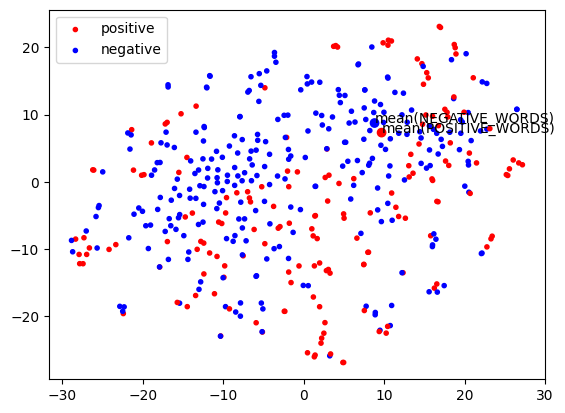

In [15]:
#| echo: true
#| code-fold: true
#| code-summary: plotting positive and negative words on a t-SNE chart

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# tsne plot of my handpicked words and a bunch of champagne-words and pain words

sham_words = ["meh", "sham", "faux", "bad", "mid"]
overrides = {"faux": "foe"}

# make a list of relevant candidate pain words and champagne compound words to be plotted in the t-SNE chart
candidate_champagne_compound_words = []
candidate_pain_words = []
for sham_word in ["meh", "sham", "faux", "bad", "mid"]:
    sham_syllable = strict_word_pronunciations[overrides.get(sham_word, sham_word)][0]
    nouns_starting_with_sham_word = list(filter(
        lambda candidate_word: find_candidate_champagne_compound_words(candidate_word, sham_syllable=sham_syllable), 
        strict_noun_pronunciations.items()))
    candidate_champagne_compound_words += [n for n, pron in nouns_starting_with_sham_word]

    for candidate_champagne_compound_word, _ in nouns_starting_with_sham_word:
        for candidate_champagne_prons in zip(strict_frequent_noun_pronunciations.get(candidate_champagne_compound_word, []), 
                reduced_frequent_noun_pronunciations.get(candidate_champagne_compound_word, [])):
            for champagne_pron in candidate_champagne_prons:
    
                if sham_syllable != champagne_pron[:len(sham_syllable)] and \
                   reduce_phonemes(sham_syllable, vowel_strictness=2) != champagne_pron[:len(sham_syllable)]: 
                    # print("{} doesn't match {}, skipping".format(sham_syllable, champagne_pron)) # just for debug.
                    continue
                for (pronunciations, syllable_offset), score in zip(list(itertools.product(
                    [strict_frequent_noun_pronunciations, reduced_frequent_noun_pronunciations], 
                    [0, 1])
                                                           ), range(4, 0, -1)):
                    # gemination is only allowed for consonant-final sham words.
                    # "photograph for my real friends, real autograph for my faux friends" should be invalid
                    if syllable_offset == 1 and is_vowel(sham_syllable[-1]): continue
                    for pain_word, pain_prons in sorted(pronunciations.items(), key=lambda word_prons: -word_frequencies.get(word[0], 0)):
                        if (champagne_pron[len(sham_syllable)-syllable_offset:] in pain_prons):
                            candidate_pain_words.append(pain_word)
candidate_pain_words = list(set(candidate_pain_words))

# translating the list of words to a Numpy array of the GLoVe vectors for the words
PCA_N_COMPONENTS = 21
words = POSITIVE_WORDS + NEGATIVE_WORDS + candidate_champagne_compound_words + candidate_pain_words
words = [word for word in words if word in glove_model]
words = list(set(words)) # remove duplicates
vectors = np.array([glove_model[word] for word in words] + 
                   [np.mean([glove_model[word] for word in POSITIVE_WORDS], axis=0)] + 
                   [np.mean([glove_model[word] for word in NEGATIVE_WORDS], axis=0)])
words += ["mean(POSITIVE_WORDS)", "mean(NEGATIVE_WORDS)"]

# reducing the dimensionality of those vectors from 200 dimension to 2 with PCA and then t-SNE 
pca_reduced_vectors = PCA(n_components=PCA_N_COMPONENTS).fit_transform(vectors)
np.set_printoptions(suppress=True)
Y = TSNE(n_components=2, random_state=0).fit_transform(pca_reduced_vectors)
    
# plotting it
df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                   'y': [y for y in Y[:, 1]],
                   'words': words})
df["is_positive"] = df.words.apply(is_positive)
df["is_negative"] = df.words.apply(is_negative)

df["color"] = None
df["handpicked"] = df.words.apply(lambda x: x in HANDPICKED_POSITIVE_WORDS + HANDPICKED_NEGATIVE_WORDS)
df["marker"] = df.handpicked.apply(lambda x: "o" if x else ".")
df.loc[df.is_positive, 'color'] = "red"
df.loc[df.is_negative, 'color'] = "blue"
df.loc[df.words == "mean(POSITIVE_WORDS)", 'color'] = 'red'
df.loc[df.words == "mean(NEGATIVE_WORDS)", 'color'] = 'blue'
#df.loc[df.is_positive & df.is_negative, 'color'] = "yellow"
df.set_index('words', inplace=True)

word_df = df[~df.index.str.contains("mean(", regex=False)]
avg_df = df[df.index.str.contains("mean(", regex=False)]
for polarity in [True, False]:
    subdf = word_df[word_df.is_positive == polarity]
    plt.scatter(subdf.x, subdf.y, c=subdf.color.tolist(), marker='.', label="positive" if polarity else "negative")
plt.scatter(avg_df.x, avg_df.y, c=avg_df.color.tolist(), marker='o')
plt.gca().legend()

for word in ["mean(POSITIVE_WORDS)", "mean(NEGATIVE_WORDS)"]:    
    plt.gca().annotate(word, (df.loc[word].x, df.loc[word].y))

## Implementing our final rubric for `champagne phrases`

In [16]:
#| echo: true
#| code-fold: true
#| code-summary: "def get_best_pain_word(champagne_prons, sham_syllable):"

def get_best_pain_word(champagne_prons, sham_syllable, quiet=True, filter_by_sentiment=True):
    """
    find the most common word that matches the back half of the champagne compound word
    if we can't find one, find one that matches the back half of the champagne compound word, 
        but repeating the last phoneme of the sham word 
        (e.g. chamonix for my real friends, real money for my sham friends)
        this is "gemination" -- we double up the 
    if we still can't find one, try with reduced pronunciations
    """

    # this lets us prefer better vowel matches to worse ones, i.e.
    # ok: folkrock for my real friends, real crook for my faux friends
    # better: folkrock for my real friends, real croc for my faux friends
    # previously it prefers "crook" because crook is more frequent than croc

    # this also lets us prefer ungeminated matches over geminated ones
    
    for champagne_pron in champagne_prons:
        if sham_syllable != champagne_pron[:len(sham_syllable)] and \
           reduce_phonemes(sham_syllable, vowel_strictness=2) != champagne_pron[:len(sham_syllable)]: 
            # print("{} doesn't match {}, skipping".format(sham_syllable, champagne_pron)) # just for debug.
            continue
        for (pronunciations, syllable_offset), score in zip(list(itertools.product(
            [strict_frequent_noun_pronunciations, reduced_frequent_noun_pronunciations], 
            [0, 1])
                                                   ), range(4, 0, -1)):
            # gemination is only allowed for consonant-final sham words.
            # "photograph for my real friends, real autograph for my faux friends" should be invalid
            if syllable_offset == 1 and is_vowel(sham_syllable[-1]): continue
            for pain_word, pain_prons in sorted(pronunciations.items(), key=lambda word_prons: -word_frequencies.get(word[0], 0)):
                if (champagne_pron[len(sham_syllable)-syllable_offset:] in pain_prons) and (is_negative(pain_word) or not filter_by_sentiment):
                    return pain_word, score
    return None, None

In [17]:
#| code-summary: "def find_champagne_real_pain_phrases('faux'):"

from collections import defaultdict

def find_champagne_real_pain_phrases(sham_word, sham_word_override=None, real_word="real", quiet=True, filter_by_sentiment=True):
    # sham syllables can be any PoS and need to have the extras added.
    # e.g. "mid" and "faux" are adjectives; "meh" isn't in the CMU pron dictionary.
    sham_syllable = strict_word_pronunciations[sham_word_override or sham_word][0]
    
    nouns_starting_with_sham_word = list(filter(
        lambda candidate_word: find_candidate_champagne_compound_words(candidate_word, sham_syllable=sham_syllable), 
        strict_noun_pronunciations.items()
    ))
    if not quiet:
        print("Here are words (our candidate champagne compound words) that start with {}".format(sham_syllable))
        for noun, prons in nouns_starting_with_sham_word:
            print(f" - {noun}: {prons}")
    champagne_pain_pairs = set()
    for candidate_champagne_compound_word, _ in nouns_starting_with_sham_word:
        if filter_by_sentiment and not is_positive(candidate_champagne_compound_word): continue
        for candidate_champagne_prons in zip(strict_frequent_noun_pronunciations.get(candidate_champagne_compound_word, []), 
                reduced_frequent_noun_pronunciations.get(candidate_champagne_compound_word, [])):
            best_pain_word, score = get_best_pain_word(candidate_champagne_prons, sham_syllable, filter_by_sentiment=filter_by_sentiment)
            if best_pain_word:
                champagne_pain_pairs.add((candidate_champagne_compound_word, best_pain_word, score))    
        
    return [((f"{candidate_champagne_compound_word} for my {real_word} friends, {real_word} {pain_word} for my {sham_word} friends"),
            {"candidate_champagne_compound_word": candidate_champagne_compound_word, "real_word": real_word, "pain_word": pain_word, "sham_word": sham_word, "score": score})
            for candidate_champagne_compound_word, pain_word, score in sorted(champagne_pain_pairs, key=lambda x: -x[2])]

## ____ for my faux, sham, mid, meh and bad friends

In [18]:
#| code-summary: Finding champagne phrases if our sham word is ... 'faux'

# SHAM_WORD and SHAM_WORD_OVERRIDE were defined in the "A first try" section
# SHAM_WORD = faux
for champagne_phrase, _ in find_champagne_real_pain_phrases(SHAM_WORD, sham_word_override=SHAM_WORD_OVERRIDE):
    print(champagne_phrase)

folkrock for my real friends, real croc for my faux friends
fomite for my real friends, real might for my faux friends
photo for my real friends, real toe for my faux friends
photons for my real friends, real tons for my faux friends
fomites for my real friends, real mites for my faux friends
focus for my real friends, real cuss for my faux friends
photos for my real friends, real toes for my faux friends
photon for my real friends, real ton for my faux friends
focus for my real friends, real kis for my faux friends
folklore for my real friends, real clear for my faux friends
foliage for my real friends, real ledge for my faux friends


In [19]:
#| code-summary: Finding champagne phrases if our sham word is ... 'sham'

for champagne_phrase, _ in find_champagne_real_pain_phrases("sham"):
    print(champagne_phrase)


shamrocks for my real friends, real rocks for my sham friends
champagnes for my real friends, real pains for my sham friends
champagne for my real friends, real pain for my sham friends
shamwow for my real friends, real wow for my sham friends
shamrock for my real friends, real rock for my sham friends
shampoo for my real friends, real poo for my sham friends
chamonix for my real friends, real money for my sham friends
chamois for my real friends, real woe for my sham friends


In [20]:
#| code-summary: ... if our sham word is 'mid'

for champagne_phrase, _ in find_champagne_real_pain_phrases("mid"):
    print(champagne_phrase)


midline for my real friends, real line for my mid friends
midrash for my real friends, real rash for my mid friends
middling for my real friends, real ling for my mid friends
midpoint for my real friends, real point for my mid friends
midday for my real friends, real day for my mid friends
midnight for my real friends, real knight for my mid friends
middle for my real friends, real ell for my mid friends
medulla for my real friends, real ola for my mid friends


In [21]:
#| code-summary: ... if our sham word is 'bad'

for champagne_phrase, _ in find_champagne_real_pain_phrases("bad"):
    print(champagne_phrase)


badges for my real friends, real jaws for my bad friends


In [22]:
#| code-summary: ... if our sham word is 'meh'

for champagne_phrase, _ in find_champagne_real_pain_phrases("meh"):
    print(champagne_phrase)


marrow for my real friends, real rho for my meh friends
merits for my real friends, real ruts for my meh friends
medic for my real friends, real dick for my meh friends
married for my real friends, real reed for my meh friends
method for my real friends, real thud for my meh friends
meadows for my real friends, real doze for my meh friends
merits for my real friends, real writs for my meh friends
medics for my real friends, real dicks for my meh friends
meadow for my real friends, real doh for my meh friends
marriages for my real friends, real ridges for my meh friends
marriage for my real friends, real ridge for my meh friends
merit for my real friends, real rut for my meh friends
metric for my real friends, real trick for my meh friends
metrics for my real friends, real tricks for my meh friends
metals for my real friends, real tolls for my meh friends
medals for my real friends, real dolls for my meh friends
medico for my real friends, real deco for my meh friends
metal for my real 

In [23]:
#| code-summary: ... if our sham word is 'crap'

for champagne_phrase, _ in find_champagne_real_pain_phrases("crap"):
    print(champagne_phrase)


crappie for my real friends, real pee for my crap friends


In [24]:
#| code-summary: ... if our sham word is 'barf'

for champagne_phrase, _ in find_champagne_real_pain_phrases("barf"):
    print(champagne_phrase)


barflies for my real friends, real lies for my barf friends


(Crappie is a kind of fish.)

In [25]:
#| code-summary: ... if our sham word is 'ex'

for champagne_phrase, _ in find_champagne_real_pain_phrases("ex"):
    print(champagne_phrase)


exposition for my real friends, real position for my ex friends
extract for my real friends, real tract for my ex friends
extraction for my real friends, real traction for my ex friends
exile for my real friends, real isle for my ex friends
expos for my real friends, real pose for my ex friends
exchequer for my real friends, real checker for my ex friends
extracts for my real friends, real tracts for my ex friends
expert for my real friends, real spurt for my ex friends
exon for my real friends, real son for my ex friends
experts for my real friends, real spurts for my ex friends
excess for my real friends, real oss for my ex friends
exit for my real friends, real aught for my ex friends
exports for my real friends, real parts for my ex friends
expositions for my real friends, real possessions for my ex friends
expo for my real friends, real paw for my ex friends
export for my real friends, real part for my ex friends
exponent for my real friends, real pennant for my ex friends
extras 

In [27]:
#| echo: true
#| code-fold: true
#| code-summary: regression testing

# regression testing
assert not any(['photograph' in phrase and 'autograph' in phrase for phrase, _ in find_champagne_real_pain_phrases("faux", sham_word_override="foe")])
assert any(['shamrocks' in phrase for phrase, _ in find_champagne_real_pain_phrases("sham")])
assert any(['money' in phrase and 'chamonix' in phrase for phrase, _ in find_champagne_real_pain_phrases("sham")])
assert any(['midrash' in phrase for phrase, _ in find_champagne_real_pain_phrases("mid")])
assert any(['folkrock' in phrase for phrase, _ in find_champagne_real_pain_phrases("faux", sham_word_override="foe")])
assert any([metadata["pain_word"] == "croc" for phrase, metadata in find_champagne_real_pain_phrases("faux", sham_word_override="foe")])
assert any(['fomites' in phrase for phrase, _ in find_champagne_real_pain_phrases("faux", sham_word_override="foe")])
if NSFW_WORDS_ALLOWED:
    assert any(['badges' in phrase and unmask_nsfw('aml6eg==') in phrase for phrase, _ in find_champagne_real_pain_phrases("bad")])
else:
    assert not any(['badges' in phrase and unmask_nsfw('aml6eg==') in phrase for phrase, _ in find_champagne_real_pain_phrases("bad")])



## A worked example

Let's walk through this step by step.

Chamonix is a province in France. It has two very different pronunciations in the CMU Pronouncing Dictionary. One Americanized pronunciation, _tcham-onyx_ and a French one like _sham-oh-knee_.

(The Americanized pronunciation -- which is incorrect -- might be meant for automatic speech recognition systems akin to Siri or Alexa that would have to recognize an incorrect pronunciation, rather than for text-to-speech systems. Or it might be that this particular entry in the CMU Pronouncing Dictionary was generated by an unmotivated undergrad without a background in French.)

In [28]:
#| code-fold: false

cmudict.dict()["chamonix"]

[['CH', 'AE1', 'M', 'AH0', 'N', 'IH0', 'K', 'S'],
 ['SH', 'AE0', 'M', 'OW0', 'N', 'IY0']]

Here's what the pronunciation looks like with the stresses removed.

In [29]:
#| code-fold: false

strict_word_pronunciations["chamonix"]

[('CH', 'AE', 'M', 'AH', 'N', 'IH', 'K', 'S'),
 ('SH', 'AE', 'M', 'OW', 'N', 'IY')]

In [30]:
#| code-fold: false

sham_word = "sham"
sham_syllable = strict_word_pronunciations[sham_word][0]
sham_syllable

('SH', 'AE', 'M')

See how `('SH', 'AE', 'M')` is the first half of the second pronunciation, `('SH', 'AE', 'M', 'OW', 'N', 'IY')`

Now, we're looking to see if there are any `pain word`s that are pronounced like any of these options for the pronunciation of the back half of _chamonix_.

First, we're looking for something that matches `('OW', 'N', 'IY')` or `('M', 'OW', 'N', 'IY')` -- the back half without any vowel reductions. `('OW', 'N', 'IY')` would be preferable, since it doesn't require double-up the `M` in both the `sham word` (_sham_) and the `pain word` (_money_, in this case).

Here are those strict pronunciations that we're looking for.

In [31]:
#| code-fold: false

for chamonix_pronunciation in strict_word_pronunciations["chamonix"]:
    print(chamonix_pronunciation[len(sham_syllable):])
    print(chamonix_pronunciation[len(sham_syllable)-1:])    

('AH', 'N', 'IH', 'K', 'S')
('M', 'AH', 'N', 'IH', 'K', 'S')
('OW', 'N', 'IY')
('M', 'OW', 'N', 'IY')


Or, if we can't find something that matches the strict, we'd look for something that matches the back half of _chamonix_ with reductions.

Here's what those reduced pronunciations look like:

In [32]:
#| code-fold: false

for chamonix_pronunciation in reduced_frequent_noun_pronunciations["chamonix"]:
    print(chamonix_pronunciation[len(sham_syllable):])
    print(chamonix_pronunciation[len(sham_syllable)-1:])

('AH', 'N', 'AH', 'K', 'S')
('M', 'AH', 'N', 'AH', 'K', 'S')
('AH', 'N', 'IY')
('M', 'AH', 'N', 'IY')


With those eight acceptable pronunciations in mind, we loop through every noun in the English language, to see if any nouns are pronounced that way. We find three!

In [33]:
#| code-fold: false

strict_noun_pronunciations["money"]

[('M', 'AH', 'N', 'IY')]

In [34]:
#| code-fold: false

strict_noun_pronunciations["onyx"]

[('AA', 'N', 'IH', 'K', 'S')]

In [35]:
#| code-fold: false

strict_noun_pronunciations["annex"]

[('AE', 'N', 'EH', 'K', 'S'), ('AH', 'N', 'EH', 'K', 'S')]

None of those three words match either strict pronunciation of _chamonix_. So we get no result from `get_best_pain_word` here.

In [36]:
#| code-fold: false

get_best_pain_word(strict_noun_pronunciations["chamonix"], strict_noun_pronunciations["sham"][0])

(None, None)

But they do match the reduced pronunciation of _chamonix_. 

In [37]:
#| code-fold: false

get_best_pain_word(reduced_frequent_noun_pronunciations["chamonix"], strict_noun_pronunciations["sham"][0])

('money', 3)

_Money_ is picked becuase it is the more common than either _onyx_ or _annex_.

In [38]:
#| code-fold: false

for word in ["money", "onyx", "annex"]:
    print("frequency of {: >5} is {:,.0f} and it is {}".format(word, word_frequencies[word], "negative" if is_negative(word) else "positive"))

frequency of money is 190,205,072 and it is negative
frequency of  onyx is 2,315,135 and it is negative
frequency of annex is 8,465,905 and it is positive


## Future enhancements


### Use "a" for pain words that are count nouns

for singular, count nouns, we should add "a" (or "an") before hand, so it makes a bit more sense.

- _**a** phoney for my real friends, **a** real knee for my faux friends_

this would be tricky, because we don't want to do this for mass nouns (like _champagne_). [CUVPlus](https://llds.ling-phil.ox.ac.uk/llds/xmlui/handle/20.500.14106/2469) may be a way to do this, although it regards champagne as a count noun (erroneously, in my view).

Count nouns are those that you refer to individually. A couch, two laptops, many friends. Mass nouns are referred to regardless of their quantity: coffee, champagne, sand. Some nouns can be both, like _squirrel_. (_I like squirrels_ means something different from _I like squirrel_, which implies that you like eating squirrel meat.)

### Metrics for my real friends

compile all the examples here and get some humans to rate them on how funny they are, and see if we can't figure out some more rules to filter out the crappy ones and generate more funny ones.

### Better phonology

The vowel reduction logic above is pretty rough. My linguistics education is rusty enough that I can't write a rule to exclude false-positive matches like _medulla for my real friends, real allah for my mid friends_.

Additionally, diphthongs are often close enough to single vowels to count as a rhyme. You could imagine _Champlain for my real friends, real playin' for my sham friends_ working, but the code as of now wouldn't be able to equate _plain_ and _playin'_. 

The matching logic could also allow voiced and unvoiced consonants (that share a place of articulation) to match, which would allow sentences like _extremes for my real friends, real dreams for my ex friends_.

### Improve positive/negative classification

It'd be great to find a better way to classify pain words as negative or not. This is one place where GPT4 might do a good job! A traditional classifier based on the VADER wordlist and GLoVE vectors might also do a good enough job of capturing our very specific sense of positivity/negativity, too.

#### What about VADER (or AFINN)?

VADER is a time-tested dictionary-based sentiment analysis methodology -- that is, it's a big list of hand-picked words rated by how positive or negative they are. The code below is a first stab at using VADER to filter out pain words that aren't classified as negative. But the VADER lexicon list is relatively small, and many negative words words -- like _mites_ -- aren't on it, so many good phrases get incorrectly excluded. (Another sentiment wordlist, AFINN, only contains pain words already present in VADER.)

We'd only get these five results (which are pretty good, but fewer than we'd want) with the VADER methodology.

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_download('vader_lexicon', quiet=True)
s = SentimentIntensityAnalyzer()

overrides = {"faux": "foe"}
for sham_word in ["meh", "sham", "faux", "bad", "mid"]:
    for champagne_phrase, metadata in find_champagne_real_pain_phrases(sham_word, sham_word_override=overrides.get(sham_word)):
        if s.lexicon.get(metadata["pain_word"], 0) < 0:
            print(champagne_phrase)

medic for my real friends, real dick for my meh friends
metric for my real friends, real trick for my meh friends
metrics for my real friends, real tricks for my meh friends
champagnes for my real friends, real pains for my sham friends
champagne for my real friends, real pain for my sham friends
chamois for my real friends, real woe for my sham friends
midrash for my real friends, real rash for my mid friends


### What pain words are excluded by the existing positive/negative methodology?

In [40]:

for sham_word in ["faux", "sham", "mid", "meh", "bad"]:
    for champagne_phrase, metadata in find_champagne_real_pain_phrases(sham_word, sham_word_override=overrides.get(sham_word), filter_by_sentiment=False):
        if not is_negative(metadata["pain_word"], default=False) and \
           is_positive(metadata["candidate_champagne_compound_word"], default=True):
            print(champagne_phrase)
    print()


focuses for my real friends, real kisses for my faux friends
focusing for my real friends, real kissing for my faux friends
photons for my real friends, real tonnes for my faux friends
focuses for my real friends, real kisses for my faux friends
focusing for my real friends, real kissing for my faux friends

shamrock for my real friends, real roc for my sham friends

midwife for my real friends, real wife for my mid friends
midwives for my real friends, real wives for my mid friends
midsummer for my real friends, real summer for my mid friends

married for my real friends, real read for my meh friends
menus for my real friends, real news for my meh friends
mesquite for my real friends, real skeet for my meh friends
melons for my real friends, real lawns for my meh friends
melon for my real friends, real lawn for my meh friends




In particular, I like

- _chamonix for my real friends, real money for my sham friends_
- _menus for my real friends, real news for my meh friends_

but they don't quite fit the rubric (since neither _money_ nor _news_ is really negative.)

Thoughts? Improvements? Suggestions on more `sham words` I should plug in? Please send me an [email](https://jeremybmerrill.com/contact/), message me on [Mastodon](https://journa.host/@jeremybmerrill) or [Bluesky](https://bsky.app/profile/jeremybmerrill.com) or open a [Github issue](https://github.com/jeremybmerrill/champagne_real_pain).

In [41]:
#| echo: false
#| output: false
#| code-fold: true
#| code-summary: debugging why a word didn't show up.


# debugging:
def why_is_this_word_absent(word):
    if not is_noun(word):
        print(f"is_noun({word}) is false")
    if word in word_frequencies and word_frequencies.get(word) < MIN_FREQUENCY:
        print("{}'s frequency is {}, which is below MIN_FREQUENCY".format(word, word_frequencies.get(word), MIN_FREQUENCY))
    if word not in word_frequencies:
        print(f"{word} not in word frequencies")
    if not cmudict_pronunciations[word]:
        print(f"{word} not in cmudict")
why_is_this_word_absent('poo')
why_is_this_word_absent('shamrocks')
why_is_this_word_absent('midrash')
why_is_this_word_absent('badges')
why_is_this_word_absent('shambles')


In [42]:
#| echo: false
#| output: false
#| code-fold: true
#| code-summary: debugging the candidate pain words for a given champagne compound word

candidate_champagne_compound_word = "folkrock"
sham_syllable = word_pronunciations["foe"][0]
for champagne_prons in zip(strict_frequent_noun_pronunciations.get(candidate_champagne_compound_word, []), 
                reduced_frequent_noun_pronunciations.get(candidate_champagne_compound_word, [])):
    for champagne_pron in champagne_prons:
        print(f"considering {champagne_pron}")
        if sham_syllable != champagne_pron[:len(sham_syllable)] and \
           reduce_phonemes(sham_syllable, vowel_strictness=2) != champagne_pron[:len(sham_syllable)]: 
            print("{} doesn't match {}, skipping".format(sham_syllable, champagne_pron))
            continue
        for pronunciations, syllable_offset in list(itertools.product(
            [strict_frequent_noun_pronunciations, reduced_frequent_noun_pronunciations], 
            [0, 1])
                                                   ):
            for pain_word, pain_prons in sorted(pronunciations.items(), key=lambda word_prons: -word_frequencies.get(word[0], 0)):
                if (champagne_pron[len(sham_syllable)-syllable_offset:] in pain_prons):
                    print(pain_word)


considering ('F', 'OW', 'K', 'R', 'AA', 'K')
croc
crock
considering ('F', 'AH', 'K', 'R', 'AH', 'K')
crick
croak
croc
crock
crook
